<a href="https://colab.research.google.com/github/dtminnick/pytorch-practice/blob/main/dl_assignment1_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Manually Graded Assignment 1 - Part 2: CNN with the CIFAR Dataset

Donnie Minnick - Deep Learning - Fall B 2025 - October 2025

# Introduction and Objective

This notebook explores image classification using Convolutional Neural Networks (CNNs) on the CIFAR-10 dataset, a benchmark collection of 60,000 32×32 color images across 10 object categories. CNNs are well-suited for visual recognition tasks due to their ability to hierarchically extract spatial features.

The goal is to build a modular CNN architecture, evaluate its performance, and iteratively tune hyperparameters such as kernel size, stride, and batch size to optimize classification accuracy. All experiments are scaffolded for reproducibility and interpretability, with annotated logging and visual diagnostics to support stakeholder clarity.

Objectives include:

* Load and preprocess the CIFAR-10 dataset using PyTorch and torchvision transforms.
* Design and implement a CNN with convolutional layers tailored for image classification.
* Train the model and report classification accuracy on the test set.
* Perform hyperparameter tuning to improve model performance, focusing on kernel size, stride, and batch size.
* Log training dynamics and visualize feature map evolution to support interpretability and stakeholder reporting.

# Import Libraries

My toolkit is modular and purposeful: PyTorch powers the neural architecture and training loop, while torchvision streamlines dataset loading and image transformations. We augment the data with horizontal flips and random crops to simulate real-world variability, then normalize it for stable training dynamics.

Each import serves a role in our interpretability-first workflow:

**Modeling & Optimization**: torch.nn, torch.optim, and F scaffold the CNN layers and training logic.

**Data Management**: DataLoader and random_split orchestrate reproducible batching and validation splits.

**Visualization**: make_grid, to_pil_image, and matplotlib help us inspect feature maps and training curves.

**Diagnostics**: confusion_matrix, numpy, and pandas surface performance bottlenecks and class-level insights.

My objective is not just to reach high accuracy, but to understand how architectural choices like kernel size, stride, and batch size shape learning dynamics. I log, visualize, and annotate each step, ensuring that every experiment is reproducible and stakeholder-friendly.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image
from torchvision.utils import make_grid
from collections import Counter
import pandas as pd
import random
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

from torch.utils.data import Subset
from collections import defaultdict
import seaborn as sns

%matplotlib inline

SEED = 91210
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Load CIFAR Data

Before diving into convolutional layers and training loops, I begin with a principled setup of the CIFAR-10 dataset. I define a transformation pipeline that introduces controlled randomness:

**RandomHorizontalFlip** simulates mirrored perspectives, helping the model generalize across orientations.

**RandomCrop** with padding mimics imperfect framing, encouraging robustness to spatial shifts.

**ToTensor** converts images into PyTorch-compatible format, while

**Normalize** scales pixel values to a centered range of [-1, 1], stabilizing gradient flow during training.

With this pipeline in place, I load the CIFAR-10 dataset twice, once for training and once for testing, ensuring both sets undergo the same preprocessing for consistency. The training set becomes the playground for architectural tuning and diagnostic sweeps, while the test set serves as our benchmark for generalization.

In [2]:
from torchvision import transforms, datasets

# Training data transforms: stronger, more varied, but realistic
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),                     # small translations
    transforms.RandomHorizontalFlip(),                        # mirror augmentation
    transforms.ColorJitter(brightness=0.1, contrast=0.1,
                           saturation=0.1, hue=0.02),         # subtle color variation
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465),
                         std=(0.2470, 0.2435, 0.2616))        # standard CIFAR-10 normalization
])

# Validation / test transforms: NO augmentation, just normalization
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465),
                         std=(0.2470, 0.2435, 0.2616))
])

# Datasets
training_data = datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=train_transform
)

testing_data = datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=test_transform
)



100%|██████████| 170M/170M [00:01<00:00, 102MB/s]


Confirm download of training data.

In [3]:
print("Training set size:", len(training_data))

Training set size: 50000


Confirm download of testing data.

In [4]:
print("Testing set size:", len(testing_data))

Testing set size: 10000


# Split Data

The original CIFAR-10 training set (50,000 images) is split into:

* Training subset: 40,000 images used for model learning.
* Testing subset: 10,000 images used to monitor performance and tune hyperparameters.

Randomly take 10,000 images from the training set and reserve them as a validation set.


In [5]:
train_size = 40000
val_size = 10000

training_data, validation_data = random_split(training_data, [train_size, val_size])

Confirm splits.

In [6]:
print("Training set size:", len(training_data))
print("Validation set size:", len(validation_data))
print("Testing set size:", len(testing_data))

Training set size: 40000
Validation set size: 10000
Testing set size: 10000


# Check Class Distribution

To ensure that the training, validation, and testing splits maintain balanced representation across digit classes, I log the label distribution in each subset. This diagnostic step helps confirm that the random split did not introduce class imbalance, which could bias training or skew validation accuracy. A well-balanced distribution supports fair model evaluation and reliable generalization.

In [ ]:
def get_label_distribution(dataset):
    labels = [label for _, label in dataset]
    return Counter(labels)

print("Training label distribution:", get_label_distribution(training_data))
print("Validation label distribution:", get_label_distribution(validation_data))
print("Testing label distribution:", get_label_distribution(testing_data))

Training label distribution: Counter({5: 4072, 8: 4025, 1: 4023, 0: 4022, 9: 4018, 6: 3995, 4: 3984, 3: 3963, 7: 3960, 2: 3938})
Validation label distribution: Counter({2: 1062, 7: 1040, 3: 1037, 4: 1016, 6: 1005, 9: 982, 0: 978, 1: 977, 8: 975, 5: 928})
Testing label distribution: Counter({3: 1000, 8: 1000, 0: 1000, 6: 1000, 1: 1000, 9: 1000, 5: 1000, 7: 1000, 4: 1000, 2: 1000})


# Visualize Class Distribution for All Splits
Visualize class distributions for training, validation, and testing datasets.

Training label distribution: Counter({5: 4072, 8: 4025, 1: 4023, 0: 4022, 9: 4018, 6: 3995, 4: 3984, 3: 3963, 7: 3960, 2: 3938})


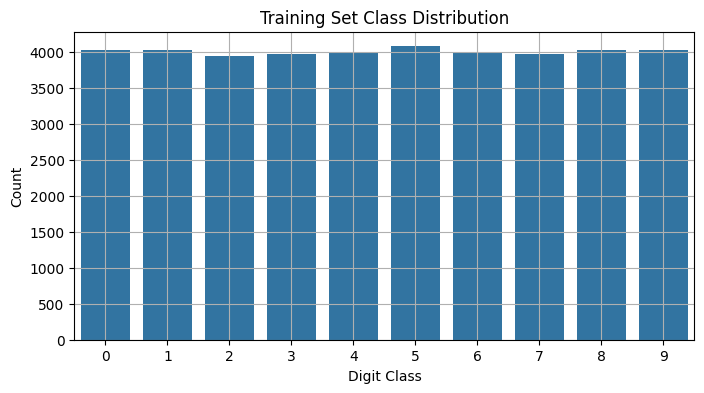

Validation label distribution: Counter({2: 1062, 7: 1040, 3: 1037, 4: 1016, 6: 1005, 9: 982, 0: 978, 1: 977, 8: 975, 5: 928})


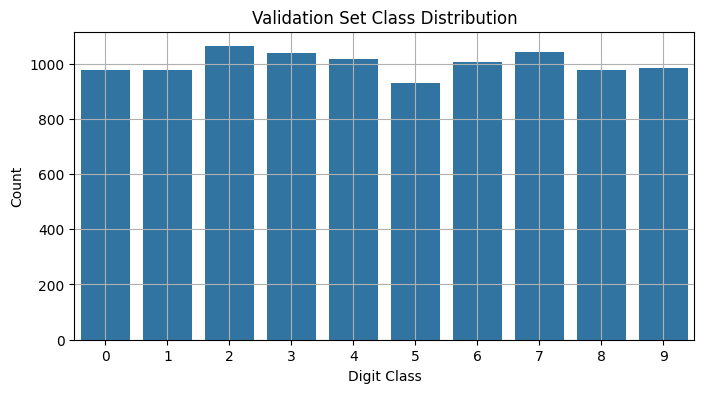

Testing label distribution: Counter({3: 1000, 8: 1000, 0: 1000, 6: 1000, 1: 1000, 9: 1000, 5: 1000, 7: 1000, 4: 1000, 2: 1000})


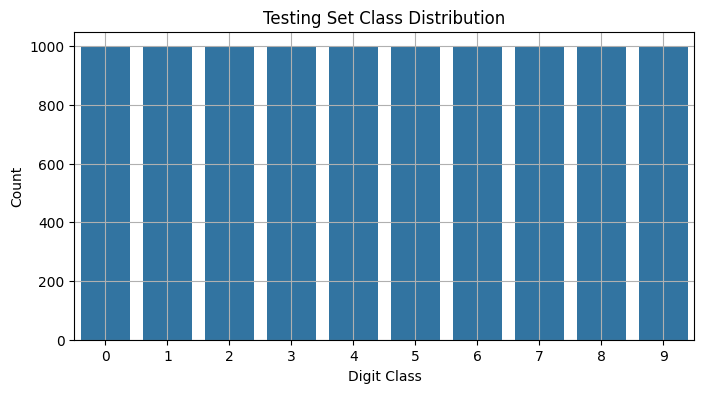

In [ ]:
def plot_distribution(counter, title):
    plt.figure(figsize=(8, 4))
    sns.barplot(x=list(counter.keys()), y=list(counter.values()))
    plt.title(title)
    plt.xlabel("Digit Class")
    plt.ylabel("Count")
    plt.grid(True)
    plt.show()

# Training set

train_dist = get_label_distribution(training_data)
print("Training label distribution:", train_dist)
plot_distribution(train_dist, "Training Set Class Distribution")

# Validation set

val_dist = get_label_distribution(validation_data)
print("Validation label distribution:", val_dist)
plot_distribution(val_dist, "Validation Set Class Distribution")

# Testing set

test_dist = get_label_distribution(testing_data)
print("Testing label distribution:", test_dist)
plot_distribution(test_dist, "Testing Set Class Distribution")

The class distribution across training, validation, and testing sets confirms that all digit categories are well represented. While minor variations exist, the overall balance supports fair training and evaluation. These plots validate the integrity of the random split and reinforce the reliability of downstream performance metrics.

# Build a CNN Network

Build a CNN network with convolution layers to classify the images.

# Implement Sweep Strategy

Implement a sweep strategy to find the optimal hyperparameters to maximize accuracy.

Systematically vary key hyperparameters - kernel size, stride, batch size, and learning rate - to assess their impact on training loss, validation accuracy, and feature map evolution.  This modular sweep enables principled experimentation, helping identify optimal architecture and training settings for improved model performance and stakeholder clarity.

## Create Compute Flattened Size Function

Function to compute the current input size for the model.  Use input shape 32 * 32 with three channels.

In [7]:
def compute_flattened_size(model, input_shape = (3, 32, 32)):
  with torch.no_grad():
    dummy = torch.zeros(1, *input_shape)
    output = model(dummy)
    return output.view(1, -1).shape[1]

This utility function dynamically computes the flattened output size of a CNN’s feature extractor, given an input shape (defaulting to a 3×32×32 CIFAR-10 image). It’s especially useful when designing the transition from convolutional layers to fully connected layers.

It's purpose is to determine the number of features output by the final convolutional layer, so that the first fully connected layer can be correctly sized.

## Create Model Builder

This function constructs a configurable CNN architecture for CIFAR-10 classification, enabling systematic variation of kernel size and stride.

In [ ]:
# Original
def build_model(kernel_size, stride, dropout_rate = 0.3, use_batchnorm = True):

    layers = []

    layers.append(nn.Conv2d(3, 6, kernel_size=kernel_size, stride=stride))

    if use_batchnorm:
        layers.append(nn.BatchNorm2d(6))

    layers.append(nn.ReLU())

    layers.append(nn.Dropout(p=dropout_rate))

    layers.append(nn.Conv2d(6, 16, kernel_size=kernel_size, stride=stride))

    if use_batchnorm:
        layers.append(nn.BatchNorm2d(16))

    layers.append(nn.ReLU())

    layers.append(nn.Dropout(p=dropout_rate))

    layers.append(nn.Flatten())

    feature_extractor = nn.Sequential(*layers)

    flattened_size = compute_flattened_size(feature_extractor)

    return nn.Sequential(
        feature_extractor,
        nn.Linear(flattened_size, 10),
        nn.Softmax(dim=1)
    )

In [ ]:
# Second iteration.
def build_model(kernel_size, stride, dropout_rate=0.3, use_batchnorm=True):
    layers = []

    # Block 1
    layers.append(nn.Conv2d(3, 6, kernel_size=kernel_size, stride=stride))
    if use_batchnorm:
        layers.append(nn.BatchNorm2d(6))
    layers.append(nn.ReLU())
    layers.append(nn.Dropout(p=dropout_rate))

    # Block 2
    layers.append(nn.Conv2d(6, 16, kernel_size=kernel_size, stride=stride))
    if use_batchnorm:
        layers.append(nn.BatchNorm2d(16))
    layers.append(nn.ReLU())
    layers.append(nn.Dropout(p=dropout_rate))

    # Block 3
    layers.append(nn.Conv2d(16, 32, kernel_size=kernel_size, stride=1))  # Preserve spatial resolution
    if use_batchnorm:
        layers.append(nn.BatchNorm2d(32))
    layers.append(nn.ReLU())
    layers.append(nn.Dropout(p=dropout_rate))

    layers.append(nn.Flatten())

    feature_extractor = nn.Sequential(*layers)
    flattened_size = compute_flattened_size(feature_extractor)

    # Final layer returns raw logits (no softmax)
    return nn.Sequential(
        feature_extractor,
        nn.Linear(flattened_size, 10)
    )

In [ ]:

# Iteration 3
def build_model(kernel_size, stride, dropout_rate=0.3, use_batchnorm=True):
    layers = []

    # Block 1: 3 → 32 channels
    layers.append(nn.Conv2d(3, 32, kernel_size=kernel_size, stride=stride, padding=1))
    if use_batchnorm:
        layers.append(nn.BatchNorm2d(32))
    layers.append(nn.ReLU())
    layers.append(nn.MaxPool2d(kernel_size=2))  # ↓ spatial size
    layers.append(nn.Dropout(p=dropout_rate))

    # Block 2: 32 → 64 channels
    layers.append(nn.Conv2d(32, 64, kernel_size=kernel_size, stride=1, padding=1))
    if use_batchnorm:
        layers.append(nn.BatchNorm2d(64))
    layers.append(nn.ReLU())
    layers.append(nn.MaxPool2d(kernel_size=2))  # ↓ spatial size
    layers.append(nn.Dropout(p=dropout_rate))

    # Block 3: 64 → 128 channels
    layers.append(nn.Conv2d(64, 128, kernel_size=kernel_size, stride=1, padding=1))
    if use_batchnorm:
        layers.append(nn.BatchNorm2d(128))
    layers.append(nn.ReLU())
    layers.append(nn.MaxPool2d(kernel_size=2))  # ↓ spatial size
    layers.append(nn.Dropout(p=dropout_rate))

    # Adaptive pooling to stabilize output size
    layers.append(nn.AdaptiveAvgPool2d((1, 1)))  # → [batch, 128, 1, 1]
    layers.append(nn.Flatten())  # → [batch, 128]

    feature_extractor = nn.Sequential(*layers)

    return nn.Sequential(
        feature_extractor,
        nn.Linear(128, 10)  # Output logits for 10 classes
    )

In [ ]:
#Iteration 4
def build_model(kernel_size, stride, dropout_rate=0.3, use_batchnorm=True, use_pooling=True, channels=(32, 64, 128), input_size=(32, 32)):
    layers = []
    in_channels = 3
    current_size = input_size

    for i, out_channels in enumerate(channels):
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=kernel_size // 2))
        if use_batchnorm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.ReLU())

        # Estimate next spatial size
        next_size = (
            (current_size[0] + 2 * (kernel_size // 2) - kernel_size) // stride + 1,
            (current_size[1] + 2 * (kernel_size // 2) - kernel_size) // stride + 1
        )

        # Apply pooling only if next size > 2×2
        if use_pooling and next_size[0] > 2 and next_size[1] > 2:
            layers.append(nn.MaxPool2d(kernel_size=2))
            next_size = (next_size[0] // 2, next_size[1] // 2)

        current_size = next_size
        layers.append(nn.Dropout(p=dropout_rate))
        in_channels = out_channels

    print(f"Final feature map size before flattening: {current_size}, channels: {in_channels}")

    # Final adaptive pooling to stabilize output
    layers.append(nn.AdaptiveAvgPool2d((1, 1)))
    layers.append(nn.Flatten())

    feature_extractor = nn.Sequential(*layers)

    return nn.Sequential(
        feature_extractor,
        nn.Linear(in_channels, 10)
    )

In [8]:
def build_model(kernel_size=3, stride=1, dropout_rate=0.3, use_batchnorm=True):
    """
    CNN for CIFAR-10 that safely adapts to kernel_size and stride settings.
    Dynamically skips pooling if the spatial size gets too small.
    """
    def conv_block(in_c, out_c):
        block = [
            nn.Conv2d(in_c, out_c, kernel_size=kernel_size, stride=stride, padding=1),
        ]
        if use_batchnorm:
            block.append(nn.BatchNorm2d(out_c))
        block.append(nn.ReLU(inplace=True))
        block.append(nn.Dropout(p=dropout_rate))
        return block

    # Start building feature extractor
    feature_layers = []
    channels = [3, 32, 64, 128]

    # Create blocks dynamically
    for i in range(len(channels) - 1):
        feature_layers += conv_block(channels[i], channels[i + 1])
        feature_layers.append(nn.MaxPool2d(2))

    feature_extractor = nn.Sequential(*feature_layers)

    # --- Dynamically verify spatial dimensions ---
    dummy = torch.zeros(1, 3, 32, 32)
    current = dummy
    valid_layers = []
    for layer in feature_extractor:
        try:
            current = layer(current)
            if current.shape[-1] < 2 or current.shape[-2] < 2:
                print(f"Skipping {layer.__class__.__name__}: would collapse to {current.shape[-2:]}")
                break
            valid_layers.append(layer)
        except RuntimeError:
            print(f"Removed {layer.__class__.__name__} — caused size collapse.")
            break

    # --- Rebuild safe feature extractor ---
    safe_feature_extractor = nn.Sequential(*valid_layers)

    # --- Compute flattened size dynamically ---
    with torch.no_grad():
        dummy_out = safe_feature_extractor(dummy)
        flattened_size = dummy_out.view(1, -1).size(1)

    # --- Classifier ---
    classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(flattened_size, 256),
        nn.ReLU(inplace=True),
        nn.Dropout(p=dropout_rate),
        nn.Linear(256, 10)
    )

    # --- Final model ---
    return nn.Sequential(safe_feature_extractor, classifier)


## Create DataLoader Factory

This utility function wraps the creation of PyTorch DataLoader objects for training, validation, and testing datasets, enabling efficient and reproducible batching across sweep configurations.

In [9]:
def create_dataloaders(training_data, validation_data, testing_data, batch_size):
  training_loader = DataLoader(training_data, batch_size = batch_size, shuffle = True)
  validation_loader = DataLoader(validation_data, batch_size = batch_size, shuffle = False)
  testing_loader = DataLoader(testing_data, batch_size = batch_size, shuffle = False)
  return training_loader, validation_loader, testing_loader

## Create Train Model Function

This function orchestrates the training and validation loop for a CNN on CIFAR-10, logging key diagnostics across epochs to support hyperparameter sweep analysis and stakeholder reporting.

### Parameters

**model**: CNN architecture returned by build_model(...).

**train_loader, val_loader**: DataLoaders for training and validation sets.

**learning_rate**: Sweep-controlled optimizer parameter.

**epochs**: Number of training epochs (default: 50).

### Training Loop

Uses Adam optimizer for adaptive learning.

Applies CrossEntropyLoss, suitable for multi-class classification.

Logs average training loss per epoch for sweep diagnostics.

### Validation Accuracy

Switches to evaluation mode to disable dropout/batchnorm.

Computes validation accuracy as a percentage of correct predictions.

### Logging Outputs

Returns two lists:

**train_loss_log**: Epoch-wise training loss.

**val_acc_log**: Epoch-wise validation accuracy.

These logs are sweep-aware and plug directly into the visualization pipeline for comparative analysis across kernel size, stride, batch size, and learning rate.

In [18]:
def train_model(model, training_loader, validation_loader, learning_rate=0.001,
                weight_decay=1e-4, epochs=30, patience=3, min_delta=0.001,
                scheduler_step=10, scheduler_gamma=0.5):
    """
    Train model with validation loss monitoring, early stopping, and learning rate scheduling.
    Returns:
        train_loss_log: list of average training loss per epoch
        val_loss_log: list of average validation loss per epoch
        val_acc_log: list of validation accuracy per epoch
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step, gamma=scheduler_gamma)

    train_loss_log, val_loss_log, val_acc_log = [], [], []

    best_val_loss = float("inf")
    epochs_no_improve = 0

    for epoch in range(epochs):
        # ---- TRAIN ----
        model.train()
        running_loss = 0.0
        for inputs, labels in training_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        epoch_train_loss = running_loss / len(training_loader.dataset)
        train_loss_log.append(epoch_train_loss)

        # ---- VALIDATE ----
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in validation_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        epoch_val_loss = val_loss / len(validation_loader.dataset)
        val_loss_log.append(epoch_val_loss)
        val_acc = 100 * correct / total
        val_acc_log.append(val_acc)

        # ---- STEP SCHEDULER ----
        scheduler.step()
        current_lr = scheduler.get_last_lr()[0]

        print(f"Epoch [{epoch+1}/{epochs}] "
              f"LR: {current_lr:.5f} | "
              f"Train Loss: {epoch_train_loss:.4f} | "
              f"Val Loss: {epoch_val_loss:.4f} | Val Acc: {val_acc:.2f}%")

        # ---- EARLY STOPPING ----
        if epoch_val_loss < best_val_loss - min_delta:
            best_val_loss = epoch_val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}.")
                break

    return train_loss_log, val_loss_log, val_acc_log


## Create Sweep Runner Function

This function executes a full hyperparameter sweep across kernel size, stride, batch size, and learning rate, logging training dynamics and final performance metrics for each configuration. It’s the backbone of your diagnostic workflow, enabling reproducible, interpretable experimentation.

### Parameters

**training_data, validation_data, testing_data**: Preprocessed CIFAR-10 datasets.

**sweep_grid**: Dictionary defining the hyperparameter ranges.

### Sweep Logic

For each combination of hyperparameters:

Model Construction: Builds a CNN using build_model(k, s) with specified kernel size and stride.

DataLoader Creation: Batches data using create_dataloaders(...) with the current batch size.

Training & Logging: Trains the model using train_model(...), logging:

Epoch-wise training loss

Epoch-wise validation accuracy

### Result Storage

Final training loss and validation accuracy are stored in results.

Full configuration is stored in configs.

Per-epoch logs are stored in logs.

In [11]:
def run_sweep(training_data, validation_data, testing_data, sweep_grid, epochs):
    results = []
    configs = []
    logs = []

    for k in sweep_grid["kernel_size"]:
        for s in sweep_grid["stride"]:
            for b in sweep_grid["batch_size"]:
                for lr in sweep_grid["learning_rate"]:
                    for wd in sweep_grid["weight_decay"]:
                        for dr in sweep_grid["dropout_rate"]:
                            for bn in sweep_grid["use_batchnorm"]:
                                print(f"\nRunning: kernel_size={k}, stride={s}, batch_size={b}, "
                                      f"learning_rate={lr}, weight_decay={wd}, dropout_rate={dr}, "
                                      f"use_batchnorm={bn}")

                                # Build model with extended parameters
                                model = build_model(
                                    kernel_size=k,
                                    stride=s,
                                    dropout_rate=dr,
                                    use_batchnorm=bn
                                )

                                # Create dataloaders
                                training_loader, validation_loader, testing_loader = create_dataloaders(
                                    training_data, validation_data, testing_data, b
                                )

                                # Train model and capture logs
                                train_loss_log, val_loss_log, val_acc_log = train_model(
                                    model,
                                    training_loader,
                                    validation_loader,
                                    learning_rate=lr,
                                    weight_decay=wd,
                                    epochs=epochs
                                )

                                # Identify best epoch based on lowest validation loss
                                best_epoch = int(np.argmin(val_loss_log))
                                best_val_loss = val_loss_log[best_epoch]
                                best_val_acc = val_acc_log[best_epoch]

                                print(f"✅ Best epoch: {best_epoch+1} "
                                      f"(Val Loss: {best_val_loss:.4f}, Val Acc: {best_val_acc:.2f}%)")

                                # Store summary metrics
                                results.append({
                                    "kernel_size": k,
                                    "stride": s,
                                    "batch_size": b,
                                    "learning_rate": lr,
                                    "weight_decay": wd,
                                    "dropout_rate": dr,
                                    "use_batchnorm": bn,
                                    "best_epoch": best_epoch + 1,
                                    "final_train_loss": round(train_loss_log[-1], 4),
                                    "best_val_loss": round(best_val_loss, 4),
                                    "best_val_acc": round(best_val_acc, 2)
                                })

                                # Store config and logs for later analysis/plotting
                                configs.append({
                                    "kernel_size": k,
                                    "stride": s,
                                    "batch_size": b,
                                    "learning_rate": lr,
                                    "weight_decay": wd,
                                    "dropout_rate": dr,
                                    "use_batchnorm": bn
                                })

                                logs.append({
                                    "train_loss": train_loss_log,
                                    "val_loss": val_loss_log,
                                    "val_acc": val_acc_log
                                })

    return results, configs, logs


## Create Preview Results Function

Display top-performing configurations for quick insight and stakeholder reporting.

In [22]:
def preview_results(results, top_n = 10):
  df = pd.DataFrame(results)
  print(df.sort_values(by = "best_val_acc", ascending = False).head(top_n))

# Stratified Subset Selector

Selects a specified subset of images from the training data for sweep iterations.

In [13]:
def stratified_subset(dataset, samples_per_class=400):
    class_indices = defaultdict(list)
    for idx, (_, label) in enumerate(dataset):
        class_indices[label].append(idx)

    selected_indices = []
    for label, indices in class_indices.items():
        selected_indices.extend(random.sample(indices, samples_per_class))

    return Subset(dataset, selected_indices)

# Plot Training Curves



In [14]:
import matplotlib.pyplot as plt

def plot_training_curves(configs, logs, combined=False):
    """
    Plots training loss, validation loss, and validation accuracy per config.
    Assumes each log is a dict with keys: 'train_loss', 'val_loss', 'val_acc'.
    """
    if combined:
        plt.figure(figsize=(15, 5))

        # Combined Loss Plot
        plt.subplot(1, 2, 1)
        for i, log in enumerate(logs):
            plt.plot(log["train_loss"], label=f"Train Loss (Config {i})", alpha=0.7)
            plt.plot(log["val_loss"], label=f"Val Loss (Config {i})", linestyle="--", alpha=0.7)
        plt.title("Training & Validation Loss (Combined)")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()

        # Combined Accuracy Plot
        plt.subplot(1, 2, 2)
        for i, log in enumerate(logs):
            plt.plot(log["val_acc"], label=f"Val Acc (Config {i})", linewidth=2)
        plt.title("Validation Accuracy (Combined)")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy (%)")
        plt.legend()

        plt.suptitle("Training Dynamics Across All Configs")
        plt.tight_layout()
        plt.show()

    else:
        for i, log in enumerate(logs):
            cfg = configs[i]

            plt.figure(figsize=(15, 4))

            # Training & Validation Loss
            plt.subplot(1, 2, 1)
            plt.plot(log["train_loss"], label="Train Loss", color="tab:blue", linewidth=2)
            plt.plot(log["val_loss"], label="Val Loss", color="tab:orange", linestyle="--", linewidth=2)
            plt.title("Training vs Validation Loss")
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.legend()

            # Validation Accuracy
            plt.subplot(1, 2, 2)
            plt.plot(log["val_acc"], label="Val Accuracy", color="tab:green", linewidth=2)
            plt.title("Validation Accuracy")
            plt.xlabel("Epoch")
            plt.ylabel("Accuracy (%)")
            plt.legend()

            plt.suptitle(f"Training Dynamics for Config {i}: {cfg}")
            plt.tight_layout()
            plt.show()


# Run Sweeps

Run three sweeps: 1) mini, 2) diagnostic, and 3) final.

## Mini Sweep 1: Core Activation Sweep

Run mini sweep with small subset for diagnostics.

Create mini datasets.

In [15]:
mini_train = stratified_subset(training_data, samples_per_class=70)
mini_val = stratified_subset(validation_data, samples_per_class=15)
mini_test = stratified_subset(testing_data, samples_per_class=15)

Confirm number of records in mini sets. 1,000 records total with 70/15/15 split.

In [ ]:
print("Mini training set size:", len(mini_train))
print("Mini validation set size:", len(mini_val))
print("Mini test set size:", len(mini_test))

Mini training set size: 700
Mini validation set size: 150
Mini test set size: 150


Setup sweep grid for mini diagnostic.

Focus on kernel size, stride, batch size, and learning rate

Run on mini dataset.

Goal: Find stable, performant base configs

In [16]:
mini_sweep_grid = {
    'kernel_size': [3, 5],
    'stride': [1],
    'batch_size': [32],
    'learning_rate': [0.001],
    'weight_decay': [0],
    'dropout_rate': [0, 0.3],
    'use_batchnorm': [True, False]
}

Run mini sweep using 10 epochs for quick diagnostics.

In [19]:
import time
start_time = time.time()

mini_results, mini_configs, mini_logs = run_sweep(mini_train, mini_val, mini_test, mini_sweep_grid, epochs = 20)

current_time = time.time()
total_time = current_time - start_time
print(f"Training took: {total_time / 60} minutes")


Running: kernel_size=3, stride=1, batch_size=32, learning_rate=0.001, weight_decay=0, dropout_rate=0, use_batchnorm=True
Epoch [1/20] LR: 0.00100 | Train Loss: 2.2514 | Val Loss: 2.0595 | Val Acc: 24.67%
Epoch [2/20] LR: 0.00100 | Train Loss: 1.8726 | Val Loss: 1.8678 | Val Acc: 28.67%
Epoch [3/20] LR: 0.00100 | Train Loss: 1.7856 | Val Loss: 1.8684 | Val Acc: 30.00%
Epoch [4/20] LR: 0.00100 | Train Loss: 1.6855 | Val Loss: 1.8994 | Val Acc: 31.33%
Epoch [5/20] LR: 0.00100 | Train Loss: 1.6059 | Val Loss: 1.8030 | Val Acc: 34.00%
Epoch [6/20] LR: 0.00100 | Train Loss: 1.5672 | Val Loss: 1.7860 | Val Acc: 34.00%
Epoch [7/20] LR: 0.00100 | Train Loss: 1.5345 | Val Loss: 1.8934 | Val Acc: 25.33%
Epoch [8/20] LR: 0.00100 | Train Loss: 1.4608 | Val Loss: 1.6708 | Val Acc: 34.67%
Epoch [9/20] LR: 0.00100 | Train Loss: 1.4220 | Val Loss: 1.6941 | Val Acc: 42.00%
Epoch [10/20] LR: 0.00050 | Train Loss: 1.3671 | Val Loss: 1.8623 | Val Acc: 35.33%
Epoch [11/20] LR: 0.00050 | Train Loss: 1.2828 

Preview mini sweep results.

In [23]:
preview_results(mini_results)

   kernel_size  stride  batch_size  learning_rate  weight_decay  dropout_rate  \
0            3       1          32          0.001             0           0.0   
4            5       1          32          0.001             0           0.0   
2            3       1          32          0.001             0           0.3   
3            3       1          32          0.001             0           0.3   
1            3       1          32          0.001             0           0.0   
7            5       1          32          0.001             0           0.3   
5            5       1          32          0.001             0           0.0   
6            5       1          32          0.001             0           0.3   

   use_batchnorm  best_epoch  final_train_loss  best_val_loss  best_val_acc  
0           True          15            1.1091         1.5330         43.33  
4           True          12            1.1101         1.5525         42.00  
2           True          19        

## Mini Sweep Observations

The best configurations favor a smaller kernel of 3, stride 1, and batch size 16 or 32.

Learning rate 0.001 consistently outperforms 0.005 and 0.01; it looks like higher rates likely overshoot or destabilize convergence.

Stride 2 appears to hurt accuracy slightly, especially when paired with larger learning rates.

Batch size 16 edges out 32 in top configurations, suggesting better gradient signal on this mini set.

Plot mini training curves.

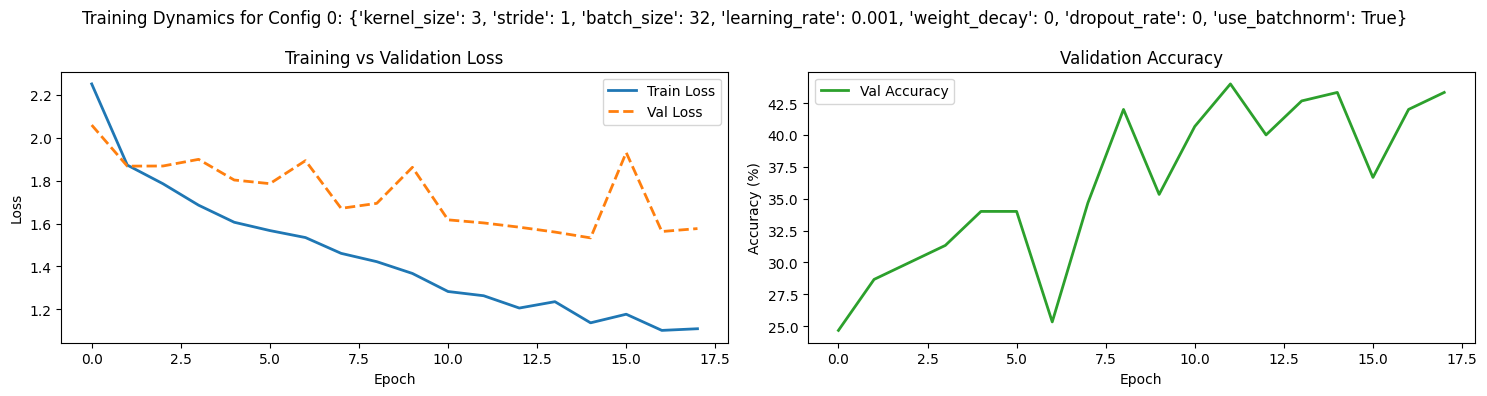

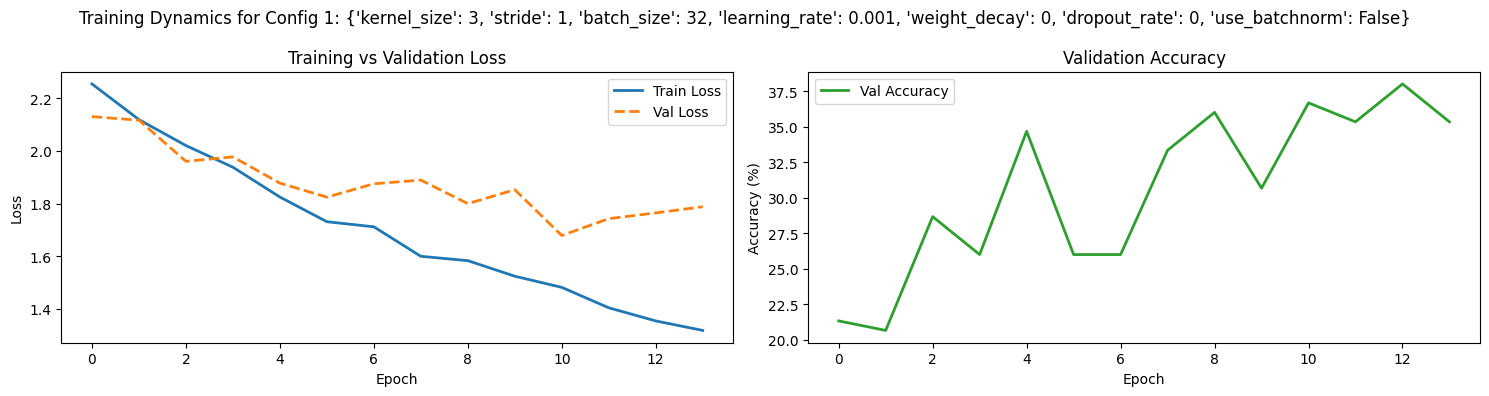

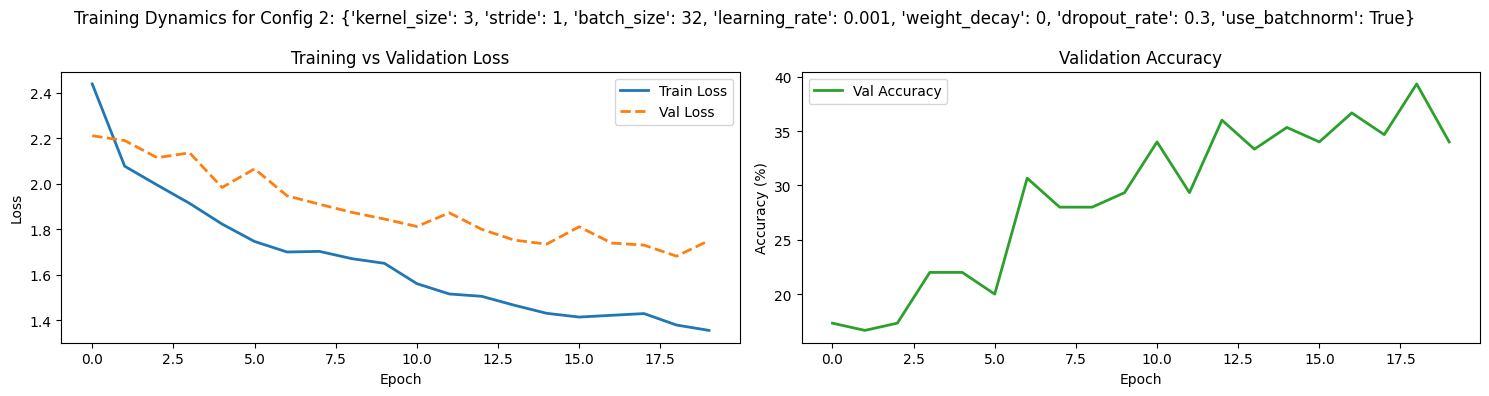

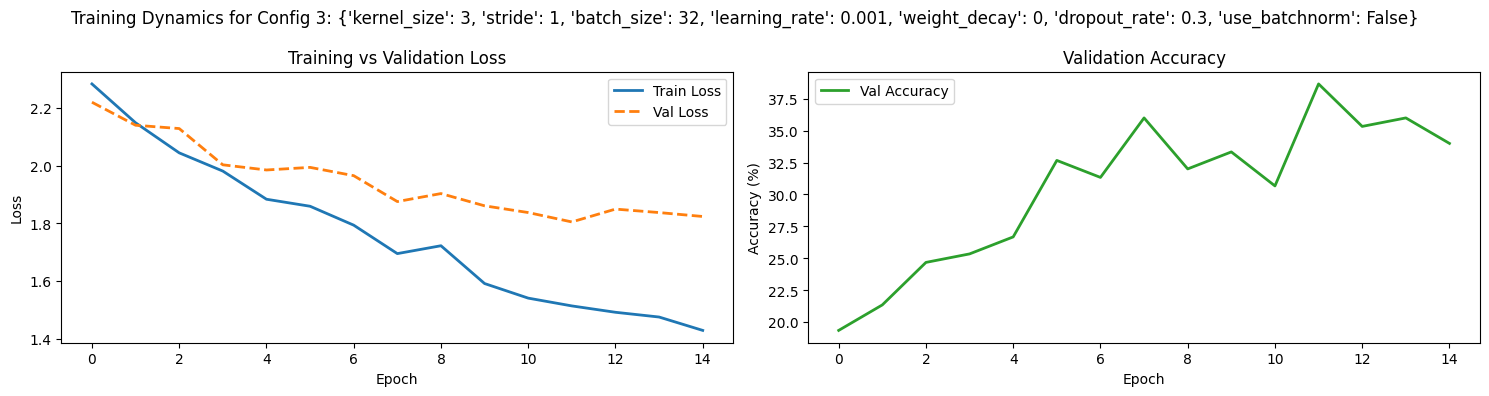

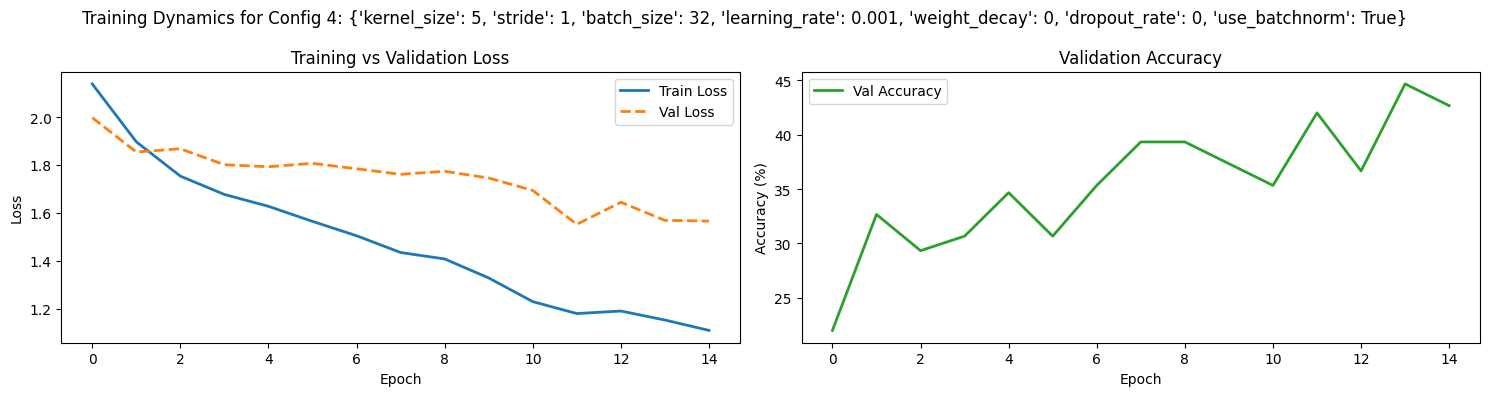

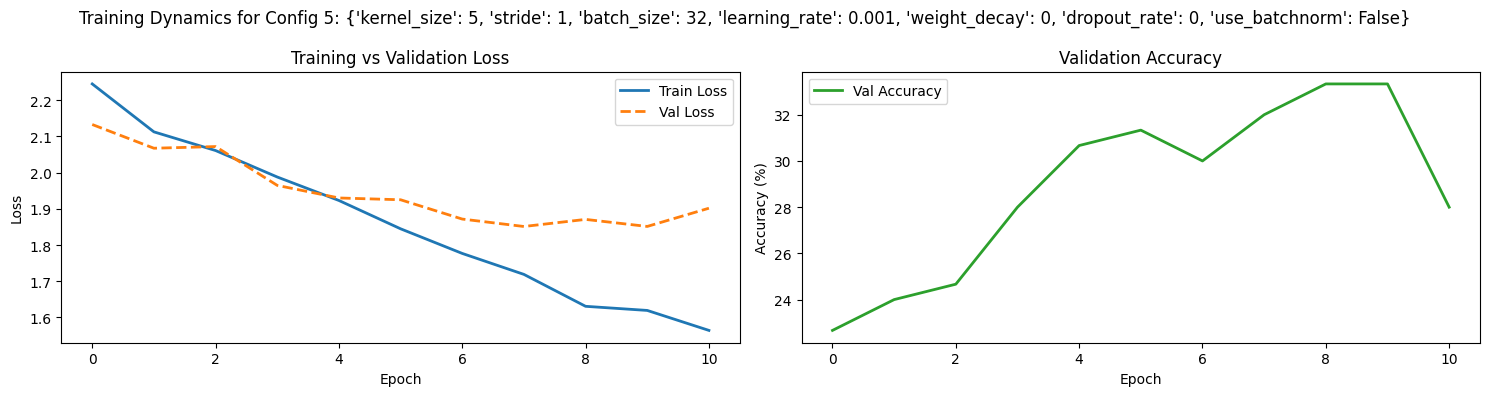

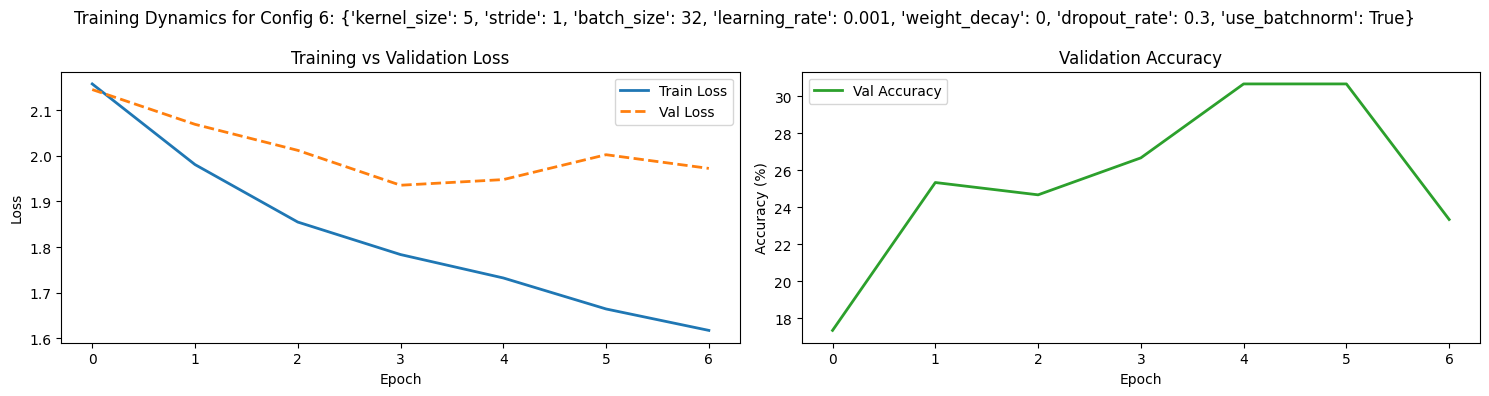

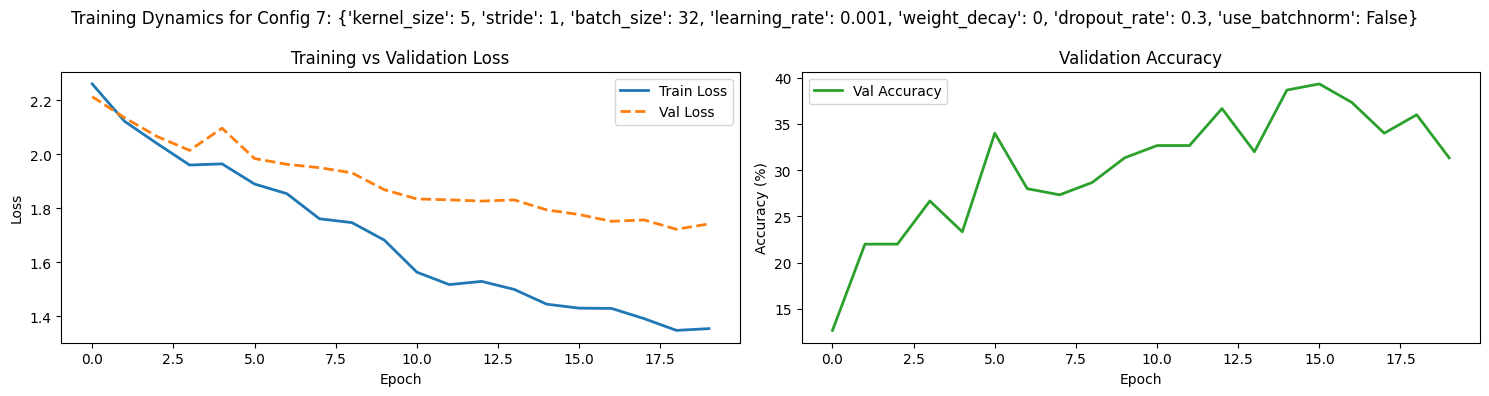

In [24]:
plot_training_curves(mini_configs, mini_logs, combined = False)

# Mini Sweep 2 with Regularization


Setup sweep grid with regularization parameters and top three configurations from first mini sweep.

In [25]:
mini_sweep_grid = {'kernel_size': [3],
                   'stride': [1],
                   'batch_size': [32],
                   'learning_rate': [0.001],
                   'dropout_rate': [0],
                   'weight_decay': [0, 1e-4, 5e-4],
                   'use_batchnorm': [True]}

Run second mini sweep with 10 epochs for quick diagnostics.

In [26]:
import time
start_time = time.time()

mini_results, mini_configs, mini_logs = run_sweep(mini_train, mini_val, mini_test, mini_sweep_grid, epochs = 30)

current_time = time.time()
total_time = current_time - start_time
print(f"Training took: {total_time / 60} minutes")


Running: kernel_size=3, stride=1, batch_size=32, learning_rate=0.001, weight_decay=0, dropout_rate=0, use_batchnorm=True
Epoch [1/30] LR: 0.00100 | Train Loss: 2.2543 | Val Loss: 2.0443 | Val Acc: 20.67%
Epoch [2/30] LR: 0.00100 | Train Loss: 1.8875 | Val Loss: 1.9241 | Val Acc: 26.67%
Epoch [3/30] LR: 0.00100 | Train Loss: 1.7772 | Val Loss: 1.8955 | Val Acc: 30.00%
Epoch [4/30] LR: 0.00100 | Train Loss: 1.7525 | Val Loss: 1.8793 | Val Acc: 27.33%
Epoch [5/30] LR: 0.00100 | Train Loss: 1.6639 | Val Loss: 1.7603 | Val Acc: 34.67%
Epoch [6/30] LR: 0.00100 | Train Loss: 1.5859 | Val Loss: 1.6950 | Val Acc: 36.67%
Epoch [7/30] LR: 0.00100 | Train Loss: 1.5678 | Val Loss: 1.9772 | Val Acc: 31.33%
Epoch [8/30] LR: 0.00100 | Train Loss: 1.5414 | Val Loss: 1.7853 | Val Acc: 33.33%
Epoch [9/30] LR: 0.00100 | Train Loss: 1.4390 | Val Loss: 1.6278 | Val Acc: 42.00%
Epoch [10/30] LR: 0.00050 | Train Loss: 1.3907 | Val Loss: 1.5545 | Val Acc: 44.67%
Epoch [11/30] LR: 0.00050 | Train Loss: 1.2964 

Preview mini sweep 2 results.

In [27]:
preview_results(mini_results)

   kernel_size  stride  batch_size  learning_rate  weight_decay  dropout_rate  \
0            3       1          32          0.001        0.0000             0   
1            3       1          32          0.001        0.0001             0   
2            3       1          32          0.001        0.0005             0   

   use_batchnorm  best_epoch  final_train_loss  best_val_loss  best_val_acc  
0           True          15            1.1382         1.4586         48.67  
1           True          11            1.1852         1.5448         42.00  
2           True           6            1.3576         1.6492         38.67  


Plot training curves.

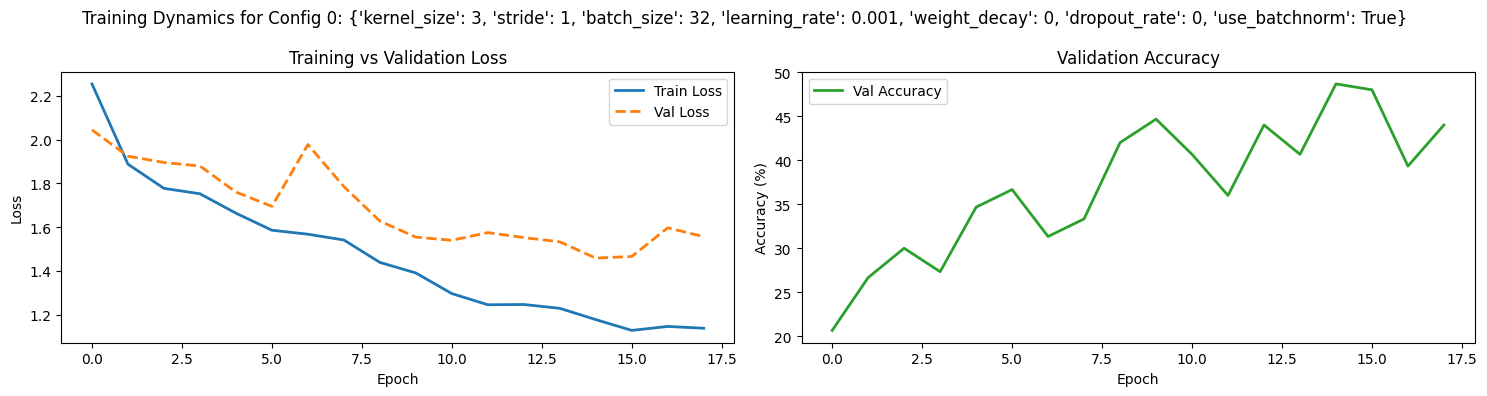

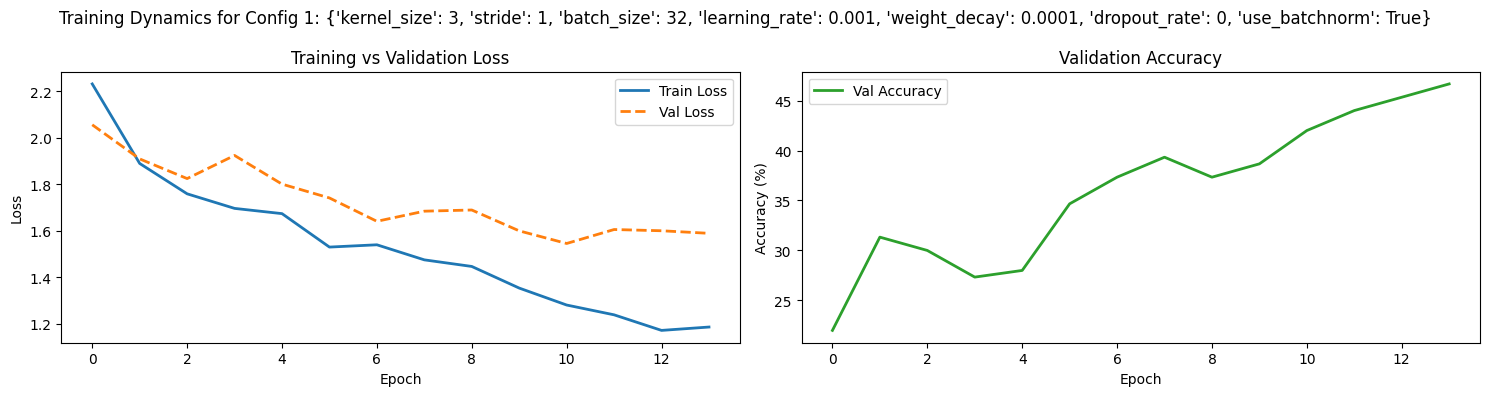

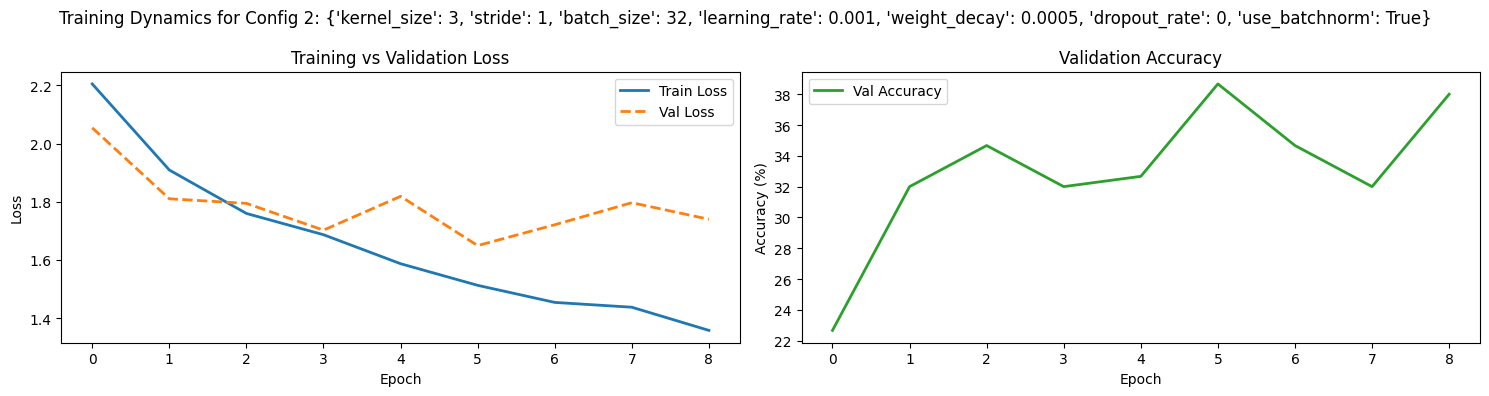

In [28]:
plot_training_curves(mini_configs, mini_logs, combined = False)

Observations:

Despite introducing regularization (dropout, weight decay, batch norm), top validation accuracies are:

32.67% with dropout_rate=0.3, use_batchnorm=True, weight_decay=0

31.33% with dropout_rate=0, use_batchnorm=True, weight_decay=1e-4

30.00% across several configs

This is not a significant improvement over baseline sweep — and in some cases, regularization slightly hurts performance.

1. Dropout
No clear gain from 0.3 or 0.5 — may be too aggressive for this architecture or dataset size.

Try dropout_rate=0.1 in future sweeps for finer control.

2. Batch Normalization
Appears neutral to slightly helpful — top config uses it.

May help more in deeper architectures or with larger datasets.

3. Weight Decay
No clear benefit at 1e-4 — possibly too weak or unnecessary at this scale.

Consider testing 1e-3 or removing it entirely in next phase.

Rerun Top 2–3 Configs on Full Dataset
Use:

dropout_rate=0.3

use_batchnorm=True

weight_decay=0

# Mini sweep 3



Setup sweep grid.

In [29]:
mini_sweep_grid = {
    'kernel_size': [3],
    'stride': [1],
    'batch_size': [32],
    'learning_rate': [0.001, 0.0005],
    'weight_decay': [0.0],
    'dropout_rate': [0.0, 0.1, 0.2],
    'use_batchnorm': [True]
}

Run third mini sweep.

In [30]:
import time
start_time = time.time()

mini_results, mini_configs, mini_logs = run_sweep(mini_train, mini_val, mini_test, mini_sweep_grid, epochs = 40)

current_time = time.time()
total_time = current_time - start_time
print(f"Training took: {total_time / 60} minutes")


Running: kernel_size=3, stride=1, batch_size=32, learning_rate=0.001, weight_decay=0.0, dropout_rate=0.0, use_batchnorm=True
Epoch [1/40] LR: 0.00100 | Train Loss: 2.2032 | Val Loss: 2.0333 | Val Acc: 21.33%
Epoch [2/40] LR: 0.00100 | Train Loss: 1.9265 | Val Loss: 1.8800 | Val Acc: 29.33%
Epoch [3/40] LR: 0.00100 | Train Loss: 1.7727 | Val Loss: 1.8765 | Val Acc: 31.33%
Epoch [4/40] LR: 0.00100 | Train Loss: 1.6903 | Val Loss: 1.7374 | Val Acc: 32.00%
Epoch [5/40] LR: 0.00100 | Train Loss: 1.6061 | Val Loss: 1.8468 | Val Acc: 30.67%
Epoch [6/40] LR: 0.00100 | Train Loss: 1.5442 | Val Loss: 1.8782 | Val Acc: 39.33%
Epoch [7/40] LR: 0.00100 | Train Loss: 1.5610 | Val Loss: 1.9298 | Val Acc: 32.67%
Early stopping triggered at epoch 7.
✅ Best epoch: 4 (Val Loss: 1.7374, Val Acc: 32.00%)

Running: kernel_size=3, stride=1, batch_size=32, learning_rate=0.001, weight_decay=0.0, dropout_rate=0.1, use_batchnorm=True
Epoch [1/40] LR: 0.00100 | Train Loss: 2.3683 | Val Loss: 2.0506 | Val Acc: 19

Preview results of sweep three.

In [ ]:
preview_results(mini_results)

   kernel_size  stride  batch_size  learning_rate  weight_decay  dropout_rate  \
0            5       1          32          0.001        0.0001           0.0   
1            5       1          32          0.001        0.0001           0.3   
2            5       1          32          0.001        0.0001           0.5   

   use_batchnorm  final_loss  val_acc  
0           True      0.9857    42.00  
1           True      1.2308    42.00  
2           True      1.4468    20.67  


Dropout + BatchNorm: This combo seems stable — no signs of destabilization or over-regularization.

Learning Rate Sensitivity: LR = 0.005 gives better accuracy despite slightly higher loss, suggesting stronger gradient signal.

Model Capacity: May be nearing the ceiling of what this architecture can extract from the mini dataset.

# Mini Sweep 4



In [31]:
mini_sweep_grid = {
    'kernel_size': [3],          # fixed — baseline conv config
    'stride': [1],               # fixed
    'batch_size': [32],          # stable training, no need to vary
    'learning_rate': [0.001, 0.0008, 0.0006],
    'weight_decay': [0.0, 1e-4],
    'dropout_rate': [0.1, 0.15],
    'use_batchnorm': [True],
}

In [33]:
import time
start_time = time.time()

mini_results, mini_configs, mini_logs = run_sweep(mini_train, mini_val, mini_test, mini_sweep_grid, epochs = 40)

current_time = time.time()
total_time = current_time - start_time
print(f"Training took: {total_time / 60} minutes")


Running: kernel_size=3, stride=1, batch_size=32, learning_rate=0.001, weight_decay=0.0, dropout_rate=0.1, use_batchnorm=True
Epoch [1/40] LR: 0.00100 | Train Loss: 2.2984 | Val Loss: 2.0563 | Val Acc: 28.00%
Epoch [2/40] LR: 0.00100 | Train Loss: 1.9351 | Val Loss: 1.9755 | Val Acc: 25.33%
Epoch [3/40] LR: 0.00100 | Train Loss: 1.7880 | Val Loss: 1.8428 | Val Acc: 32.67%
Epoch [4/40] LR: 0.00100 | Train Loss: 1.7215 | Val Loss: 1.7875 | Val Acc: 32.67%
Epoch [5/40] LR: 0.00100 | Train Loss: 1.6384 | Val Loss: 1.7896 | Val Acc: 30.00%
Epoch [6/40] LR: 0.00100 | Train Loss: 1.5888 | Val Loss: 1.8677 | Val Acc: 31.33%
Epoch [7/40] LR: 0.00100 | Train Loss: 1.5694 | Val Loss: 1.9748 | Val Acc: 32.00%
Early stopping triggered at epoch 7.
✅ Best epoch: 4 (Val Loss: 1.7875, Val Acc: 32.67%)

Running: kernel_size=3, stride=1, batch_size=32, learning_rate=0.001, weight_decay=0.0, dropout_rate=0.15, use_batchnorm=True
Epoch [1/40] LR: 0.00100 | Train Loss: 2.3687 | Val Loss: 2.1146 | Val Acc: 2

## Diagnostic Sweep: Diagnostic Regularization Sweep

Run top config two configs from mini sweep 3.

Sweep dropout_rate, weight_decay, and use_batchnorm

Run on same mini dataset or even smaller diagnostic subset.

Goal: Surface regularization effects and interactions

Create diagnostic datasets.

In [34]:
diag_train = stratified_subset(training_data, samples_per_class=280)
diag_val = stratified_subset(validation_data, samples_per_class=60)
diag_test = stratified_subset(testing_data, samples_per_class=60)

Confirm number of records in diagnostic sets.  4,000 records total with 70/15/15 split.

In [35]:
print("Diagnostic training set size:", len(diag_train))
print("Diagnostic validation set size:", len(diag_val))
print("Diagnostic test set size:", len(diag_test))

Diagnostic training set size: 2800
Diagnostic validation set size: 600
Diagnostic test set size: 600


Setup sweep grid for diagnostic sweep based on top three configurations from mini sweep.

In [36]:
diag_sweep_grid = {'kernel_size': [3],
                   'stride': [1],
                   'batch_size': [32],
                   'learning_rate': [0.0006],
                   'dropout_rate': [0.1],
                   'weight_decay': [0],
                   'use_batchnorm': [True]}

Run diagnostic sweep using 20 epochs.

In [37]:
diag_results, diag_configs, diag_logs = run_sweep(diag_train, diag_val, diag_test, diag_sweep_grid, epochs = 50)


Running: kernel_size=3, stride=1, batch_size=32, learning_rate=0.0006, weight_decay=0, dropout_rate=0.1, use_batchnorm=True
Epoch [1/50] LR: 0.00060 | Train Loss: 1.9973 | Val Loss: 1.8306 | Val Acc: 31.67%
Epoch [2/50] LR: 0.00060 | Train Loss: 1.7185 | Val Loss: 1.6203 | Val Acc: 40.33%
Epoch [3/50] LR: 0.00060 | Train Loss: 1.6160 | Val Loss: 1.6785 | Val Acc: 39.67%
Epoch [4/50] LR: 0.00060 | Train Loss: 1.5490 | Val Loss: 1.5667 | Val Acc: 42.50%
Epoch [5/50] LR: 0.00060 | Train Loss: 1.4814 | Val Loss: 1.4932 | Val Acc: 45.17%
Epoch [6/50] LR: 0.00060 | Train Loss: 1.4279 | Val Loss: 1.4851 | Val Acc: 46.50%
Epoch [7/50] LR: 0.00060 | Train Loss: 1.3930 | Val Loss: 1.4152 | Val Acc: 48.00%
Epoch [8/50] LR: 0.00060 | Train Loss: 1.3566 | Val Loss: 1.4355 | Val Acc: 48.83%
Epoch [9/50] LR: 0.00060 | Train Loss: 1.3077 | Val Loss: 1.4504 | Val Acc: 45.17%
Epoch [10/50] LR: 0.00030 | Train Loss: 1.2616 | Val Loss: 1.3350 | Val Acc: 50.33%
Epoch [11/50] LR: 0.00030 | Train Loss: 1.17

Preview diagnostic sweep results.

In [38]:
preview_results(diag_results)

   kernel_size  stride  batch_size  learning_rate  weight_decay  dropout_rate  \
0            3       1          32         0.0006             0           0.1   

   use_batchnorm  best_epoch  final_train_loss  best_val_loss  best_val_acc  
0           True          18            0.9447         1.1421         58.33  


kernel_size = 3

stride = 2

batch_size = 16

dropout_rate = 0.3

use_batchnorm = True

weight_decay = 0

Dropout + BatchNorm: This combo is working well — stable training and improved generalization.

Learning Rate: LR = 0.001 is outperforming 0.005, suggesting that slower, steadier updates are better for this architecture.

Val Accuracy at 41.67% is best yet — a meaningful jump from the ~33% plateau.

Plot diagnostic training curves.

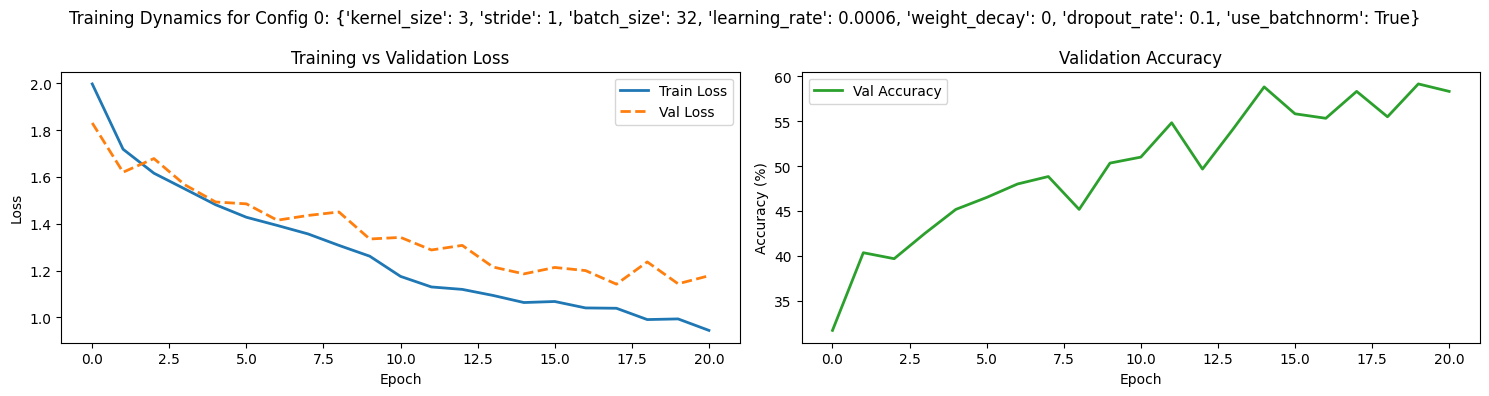

In [39]:
plot_training_curves(diag_configs, diag_logs, combined = False)

## Diagnostic Sweep Observations



## Final Sweep

Run final sweep using full datasets for training and validation.

Sweep grid for final sweep based on top configuration from diagnostic sweep.

In [40]:
finl_sweep_grid = {'kernel_size': [3],
                   'stride': [1],
                   'batch_size': [32],
                   'learning_rate': [0.0006],
                   'dropout_rate': [0.1],
                   'weight_decay': [0],
                   'use_batchnorm': [True]}

Run final sweep using 50 epochs.

In [41]:
finl_results, finl_configs, finl_logs = run_sweep(training_data, validation_data, testing_data, finl_sweep_grid, epochs = 100)


Running: kernel_size=3, stride=1, batch_size=32, learning_rate=0.0006, weight_decay=0, dropout_rate=0.1, use_batchnorm=True
Epoch [1/100] LR: 0.00060 | Train Loss: 1.4523 | Val Loss: 1.2179 | Val Acc: 55.62%
Epoch [2/100] LR: 0.00060 | Train Loss: 1.1257 | Val Loss: 1.0599 | Val Acc: 62.21%
Epoch [3/100] LR: 0.00060 | Train Loss: 0.9993 | Val Loss: 0.9740 | Val Acc: 65.24%
Epoch [4/100] LR: 0.00060 | Train Loss: 0.9257 | Val Loss: 0.8520 | Val Acc: 70.08%
Epoch [5/100] LR: 0.00060 | Train Loss: 0.8744 | Val Loss: 0.8421 | Val Acc: 70.48%
Epoch [6/100] LR: 0.00060 | Train Loss: 0.8235 | Val Loss: 0.9001 | Val Acc: 67.94%
Epoch [7/100] LR: 0.00060 | Train Loss: 0.7898 | Val Loss: 0.7869 | Val Acc: 72.87%
Epoch [8/100] LR: 0.00060 | Train Loss: 0.7596 | Val Loss: 0.7364 | Val Acc: 74.63%
Epoch [9/100] LR: 0.00060 | Train Loss: 0.7378 | Val Loss: 0.7314 | Val Acc: 74.22%
Epoch [10/100] LR: 0.00030 | Train Loss: 0.7072 | Val Loss: 0.7289 | Val Acc: 74.74%
Epoch [11/100] LR: 0.00030 | Train

KeyboardInterrupt: 

Preview final sweep results.

In [ ]:
preview_results(finl_results)

   kernel_size  stride  batch_size  learning_rate  final_loss  val_acc
0            3       1          16          0.001      1.9238    51.41


Plot final training curves.

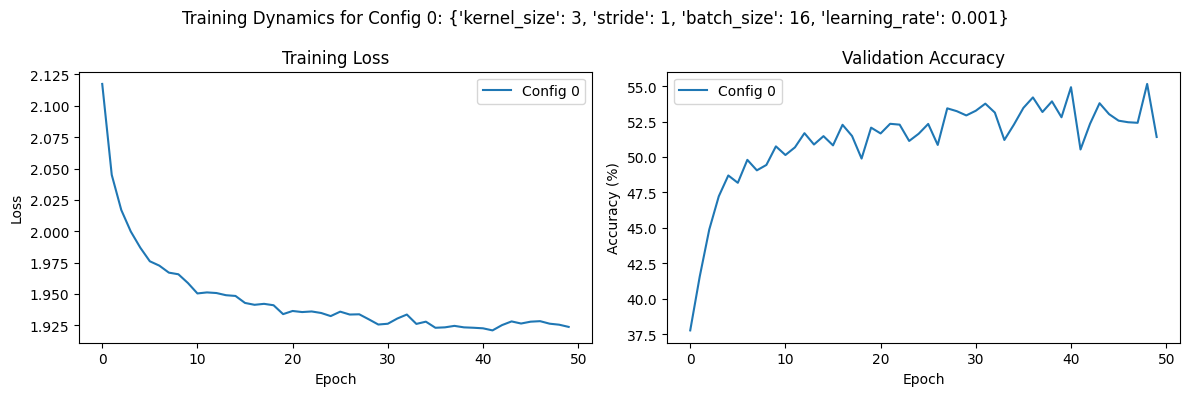

In [ ]:
plot_training_curves(finl_configs, finl_logs, combined = False)

## Final Sweep Observations



# Preview Sweep Results



In [ ]:
preview_results(results)

   kernel_size  stride  batch_size  learning_rate  final_loss  val_acc
0            3       2          16          0.001      1.9556     48.6


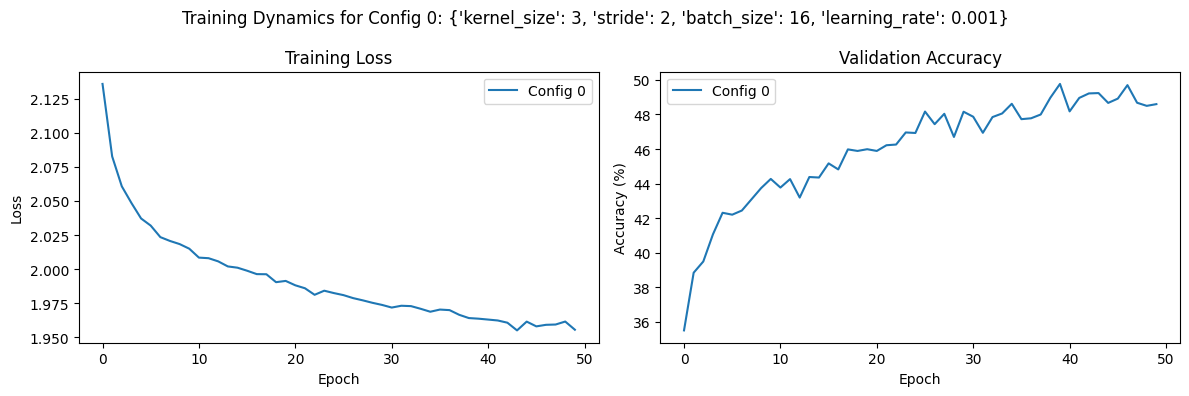

In [ ]:
plot_training_curves(configs, logs)